<a href="https://colab.research.google.com/github/nidhi0684/Project4-DiabetesPrediction/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diabetes Prediction using LogisticRegression ML Model, Binary classification**

## **Collaborators - Beauty, Luis, Nidhi, Preeti, and Steven**
## Instructions to run
*   Run all cells and locate output of last cell in PART 9
*   Click on the URL provided by google colab which looks like this *https://\<UUID\>.colab.googleusercontent.com/*
* UI for Diabetes Prediction will launch, which will take parameters such as Gender, Age, Hyptertension, Smoking History, Hb1Ac level, glucose levels.
* Click on Predict button which will pop-up a message saying proabability percentage of subject being diabetic or not.

## Code workflow
* PART 1 through PART 3 is initial setup, cloning of repository, dataset exploration and cleanup
* PART 4 is to visualize clean dataset
* PART 5 through PART 8 is building, training, testing, and saving of the ML model
* PART 9 is focused on building Flask app to build APIs that will render UI Home page and leverage ML model to predict probability of being Diabetic depending on the paremeters passed to model through Web UI


# PART 1 : Install Dependencies & Run Spark Session

In [ ]:
# Install pyspark
! pip install pyspark

from pyspark.sql.functions import when, col

In [ ]:
# Create a sparksession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark").getOrCreate()

# PART 2: Clone & Explore dataset

In [ ]:
# Cleanup code to remove Project-4 and model from /content directory so it can be cloned from github successfully
import shutil
import os

# Specify the path to Project-4 to be deleted for cloning fresh repository
directory_path = '/content/Project4-DiabetesPrediction'

# Check if the directory exists before attempting to delete it
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"The directory {directory_path} has been deleted.")
else:
    print(f"The directory {directory_path} does not exist.")

# Specify the path to model to be deleted for cloning fresh repository
directory_path = '/content/model'

# Check if the directory exists before attempting to delete it
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"The directory {directory_path} has been deleted.")
else:
    print(f"The directory {directory_path} does not exist.")

The directory /content/Project4-DiabetesPrediction has been deleted.
The directory /content/model has been deleted.


In [ ]:
# Clone the diabetes dataset from the github repository
! git clone  https://github.com/nidhi0684/Project4-DiabetesPrediction

Cloning into 'Project4-DiabetesPrediction'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 97 (delta 34), reused 82 (delta 25), pack-reused 0
Receiving objects: 100% (97/97), 3.30 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
# Check if the dataset exists
! ls /content/Project4-DiabetesPrediction/dataset

diabetes_prediction_dataset.csv  diabetes_test_dataset.csv


In [ ]:
# Create spark dataframe
df_diabetes_data = spark.read.csv("/content/Project4-DiabetesPrediction/dataset/diabetes_prediction_dataset.csv", header=True, inferSchema=True)

In [ ]:
# Display the dataframe
df_diabetes_data.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

In [ ]:
# Show amount of rows
df_diabetes_data.count()

100000

In [ ]:
# Print the schema
df_diabetes_data.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [ ]:
# Count the total no. of diabetic and non-diabetic class (values of 1 indicating the presence of diabetes and 0 indicating the absence of diabetes)
print((df_diabetes_data.count(), len(df_diabetes_data.columns)))
df_diabetes_data.groupBy('diabetes').count().show()

(100000, 9)
+--------+-----+
|diabetes|count|
+--------+-----+
|       1| 8500|
|       0|91500|
+--------+-----+



In [ ]:
# Count the total no. of gender types
print((df_diabetes_data.count(), len(df_diabetes_data.columns)))
df_diabetes_data.groupBy('gender').count().show()

(100000, 9)
+------+-----+
|gender|count|
+------+-----+
|Female|58552|
| Other|   18|
|  Male|41430|
+------+-----+



In [ ]:
# Check to see if there are any empty values in the 'gender' column
df_diabetes_data[df_diabetes_data['gender'] == '']

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, smoking_history: string, bmi: double, HbA1c_level: double, blood_glucose_level: int, diabetes: int]

In [ ]:
# Get the summary statistics
df_diabetes_data.describe().show()

+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|summary|gender|              age|      hypertension|     heart_disease|smoking_history|              bmi|       HbA1c_level|blood_glucose_level|           diabetes|
+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|  count|100000|           100000|            100000|            100000|         100000|           100000|            100000|             100000|             100000|
|   mean|  NULL|41.88585600000013|           0.07485|           0.03942|           NULL|27.32076709999422|5.5275069999983275|          138.05806|              0.085|
| stddev|  NULL|22.51683987161704|0.2631504702289171|0.1945930169980986|           NULL|6.636783416648357|1.0706720918835468|  40.70813604870383|0.27888308976661896|
|   

# PART 3: Data Cleaning & Preparation

In [ ]:
# Check for null values
for col in df_diabetes_data.columns:
  print(col + ":", df_diabetes_data[df_diabetes_data[col].isNull()].count())

gender: 0
age: 0
hypertension: 0
heart_disease: 0
smoking_history: 0
bmi: 0
HbA1c_level: 0
blood_glucose_level: 0
diabetes: 0


In [ ]:
# Function to look for the unnecessary values present
def count_zeros():
  columns_list = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
  for i in columns_list:
    print(i+":",df_diabetes_data[df_diabetes_data[i]==0].count())

In [ ]:
count_zeros()

age: 0
bmi: 0
HbA1c_level: 0
blood_glucose_level: 0


In [ ]:
# Display the dataframe
df_diabetes_data.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

In [ ]:
# Drop the 'other' rows in the gender columns
string_to_remove = "Other"
df_diabetes_data = df_diabetes_data[df_diabetes_data['Gender'] != string_to_remove]

In [ ]:
# Count the total no. of gender types
print((df_diabetes_data.count(), len(df_diabetes_data.columns)))
df_diabetes_data.groupBy('gender').count().show()

(99982, 9)
+------+-----+
|gender|count|
+------+-----+
|Female|58552|
|  Male|41430|
+------+-----+



In [ ]:
# Count the total no. of smoker/non-smoker types
print((df_diabetes_data.count(), len(df_diabetes_data.columns)))
df_diabetes_data.groupBy('smoking_history').count().show()

(99982, 9)
+---------------+-----+
|smoking_history|count|
+---------------+-----+
|    not current| 6439|
|         former| 9352|
|        No Info|35810|
|        current| 9286|
|          never|35092|
|           ever| 4003|
+---------------+-----+



In [ ]:
# Drop the 'No Info' rows in the smoking_history columns
string_to_remove_1= "No Info"
df_diabetes_data = df_diabetes_data[df_diabetes_data['smoking_history'] != string_to_remove_1]

In [ ]:
# Count the total no. of smoker/non-smoker types
print((df_diabetes_data.count(), len(df_diabetes_data.columns)))
df_diabetes_data.groupBy('smoking_history').count().show()

(64172, 9)
+---------------+-----+
|smoking_history|count|
+---------------+-----+
|    not current| 6439|
|         former| 9352|
|        current| 9286|
|          never|35092|
|           ever| 4003|
+---------------+-----+



In [ ]:
# Count the total no. of gender types after smoking_history cleanup
print((df_diabetes_data.count(), len(df_diabetes_data.columns)))
df_diabetes_data.groupBy('gender').count().show()

(64172, 9)
+------+-----+
|gender|count|
+------+-----+
|Female|38852|
|  Male|25320|
+------+-----+



In [ ]:
# Assign in the 'gender'column 'Female' = 0, and 'Male' = 1
from pyspark.sql.functions import when, col
df_diabetes_data = df_diabetes_data.withColumn("gender",
    when(col("gender") == "Female", 0).
    when(col("gender") == "Male", 1).
    otherwise(col("gender"))
)
df_diabetes_data.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|     0|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|     1|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|     0|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|     1|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|     0|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|     0|44.0|           0|            0|          never|19.31|        6.5|                200|       1|
|     1|42.0|           0|            0|          never|33.64|  

In [ ]:
# Assign in the 'smoking_history': "never" = 0, "ever" = 1, "not current" = 2, "current" = 3, "former" = 4
df_diabetes_data = df_diabetes_data.withColumn("smoking_history",
    when(col("smoking_history") == "never", 0).
    when(col("smoking_history") == "ever", 1).
    when(col("smoking_history") == "not current", 2).
    when(col("smoking_history") == "current", 3).
    when(col("smoking_history") == "former", 4).
    otherwise(col("smoking_history"))
)
df_diabetes_data.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|     0|80.0|           0|            1|              0|25.19|        6.6|                140|       0|
|     1|28.0|           0|            0|              0|27.32|        5.7|                158|       0|
|     0|36.0|           0|            0|              3|23.45|        5.0|                155|       0|
|     1|76.0|           1|            1|              3|20.14|        4.8|                155|       0|
|     0|20.0|           0|            0|              0|27.32|        6.6|                 85|       0|
|     0|44.0|           0|            0|              0|19.31|        6.5|                200|       1|
|     1|42.0|           0|            0|              0|33.64|  

# PART 4: Data Visualization after data wrangling

In [ ]:
# Import dependencies required for visulaization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
df_diabetes_pd = df_diabetes_data.toPandas()

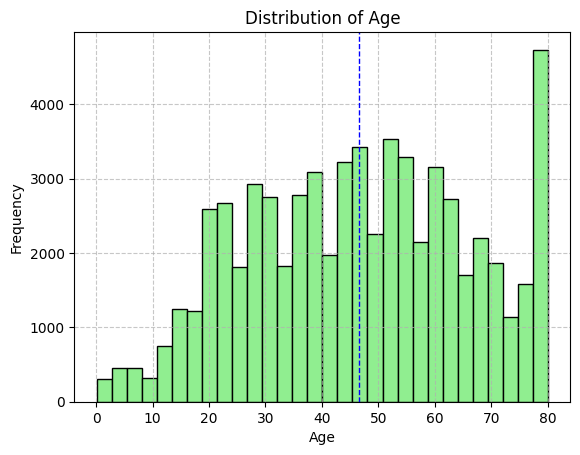

In [ ]:
# Histogram of Age
plt.hist(df_diabetes_pd['age'], bins=30, color='lightgreen', edgecolor='black')
plt.axvline(df_diabetes_pd['age'].mean(), color='b', linestyle='--', linewidth=1)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

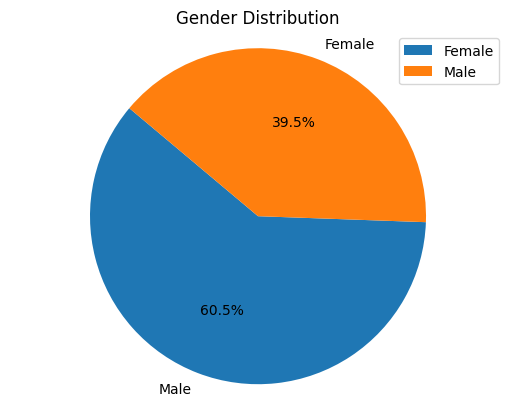

In [63]:
# Pie Chart of Gender Distribution
gender_counts = df_diabetes_pd['gender'].value_counts()
gender_counts.index = ['Male' if idx == 0 else 'Female' for idx in gender_counts.index]
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.legend(labels=['Female', 'Male'])
plt.axis('equal')
plt.show()

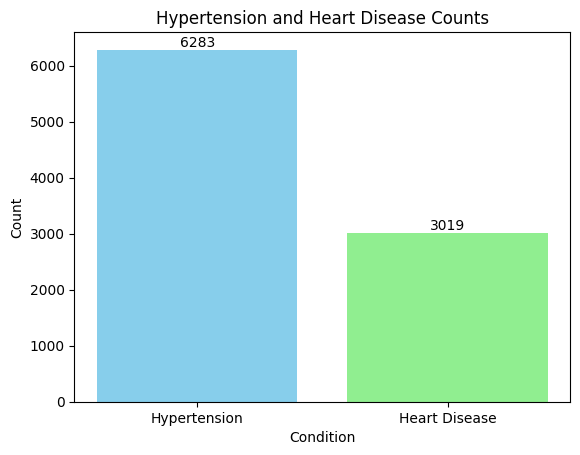

In [ ]:
# Bar Chart of Hypertension and Heart Disease
condition_counts = df_diabetes_pd[['hypertension', 'heart_disease']].sum()
conditions = ['Hypertension', 'Heart Disease']
plt.bar(conditions, condition_counts, color=['skyblue', 'lightgreen'])
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Hypertension and Heart Disease Counts')

# Add value labels on top of each bar
for i, count in enumerate(condition_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

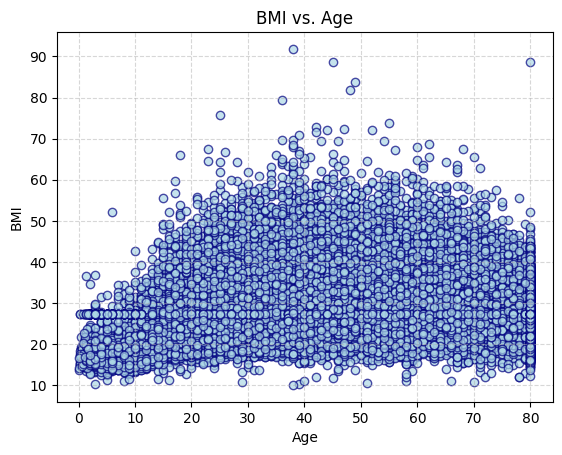

In [ ]:
# Scatter Plot of BMI vs. Age
# data points
x = df_diabetes_pd['age']
y = df_diabetes_pd['bmi']
plt.scatter(df_diabetes_pd['age'], df_diabetes_pd['bmi'], color='lightblue', alpha=0.7, edgecolor='navy')
# Add labels and title
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('BMI vs. Age')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<ipython-input-34-ecdd684bdf09>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diabetes', y='blood_glucose_level', data=df_diabetes_pd, palette='Set2')


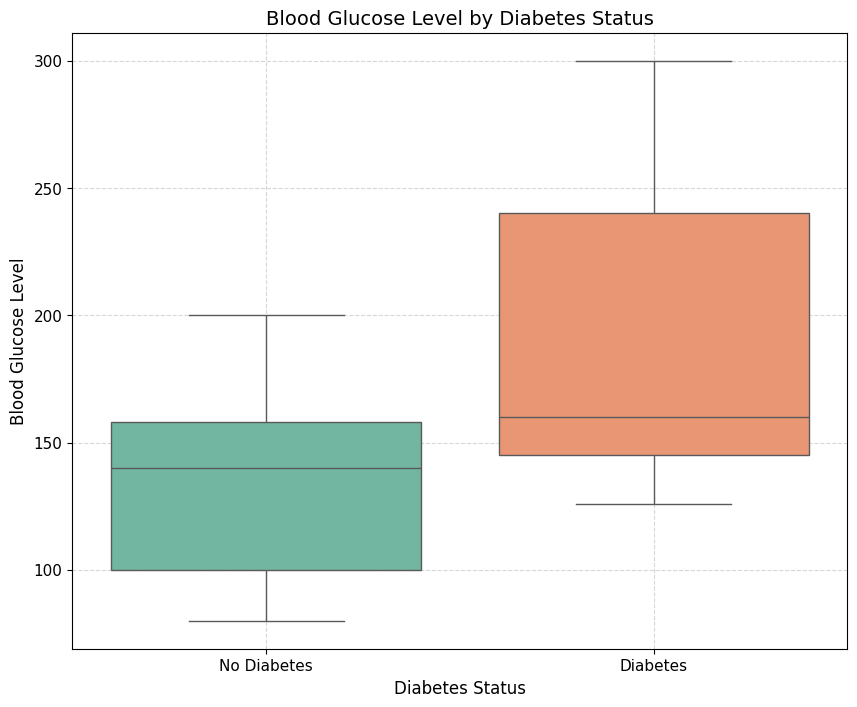

In [ ]:
# Boxplot of Blood Glucose Level by Diabetes Status
plt.figure(figsize=(10, 8))
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df_diabetes_pd, palette='Set2')
# Add labels and title
plt.xlabel('Diabetes Status', fontsize=12)
plt.ylabel('Blood Glucose Level', fontsize=12)
plt.title('Blood Glucose Level by Diabetes Status', fontsize=14)
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'], fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# gender and smoking_history needs to be converted to float data type for model to work
df_diabetes_data = df_diabetes_data.withColumn("gender", col("gender").cast('float'))
df_diabetes_data = df_diabetes_data.withColumn("smoking_history", col("smoking_history").cast('float'))


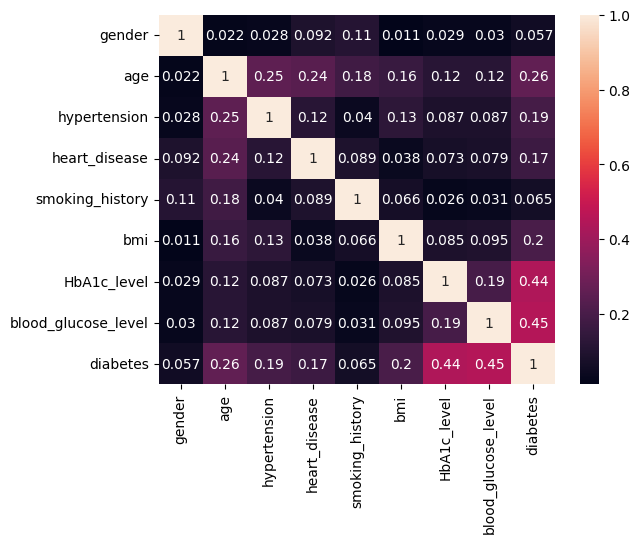

In [ ]:
# Heatmap for correlation of features with outcome
df_diabetes_pd = df_diabetes_data.toPandas()
sns.heatmap(df_diabetes_pd.corr(), annot = True)
plt.show()

# Observations from visualization
* Dataset used for this study has a balance age distrubution representing each decade of human age
* Dataset has more number of non-diabetic records than diabetic indicating inbalance nature
* Dataset has 60% female representation as opposed to 40% male
* Dataset has good representation of all possible BMI
* Dataset has sufficient representation of people with Hypertension or Heart Disease
* Dataset visualization using Boxplot and Correlation Heatmap indicates clearly that high Hb1Ac & Blood Glucose level is fairly correlated with the outcome.

# PART 5: Correlation Analysis & Feature Selection

In [ ]:
df_diabetes_data.show()


+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|   0.0|80.0|           0|            1|            0.0|25.19|        6.6|                140|       0|
|   1.0|28.0|           0|            0|            0.0|27.32|        5.7|                158|       0|
|   0.0|36.0|           0|            0|            3.0|23.45|        5.0|                155|       0|
|   1.0|76.0|           1|            1|            3.0|20.14|        4.8|                155|       0|
|   0.0|20.0|           0|            0|            0.0|27.32|        6.6|                 85|       0|
|   0.0|44.0|           0|            0|            0.0|19.31|        6.5|                200|       1|
|   1.0|42.0|           0|            0|            0.0|33.64|  

In [ ]:
# Find the correlation among the set of input & output variables
for i in df_diabetes_data.columns:
  print("Correlation to outcome for {} is {}".format(i, df_diabetes_data.stat.corr("diabetes",i)))

Correlation to outcome for gender is 0.05699689368565596
Correlation to outcome for age is 0.26084962459224337
Correlation to outcome for hypertension is 0.19222574901207254
Correlation to outcome for heart_disease is 0.16961397731730365
Correlation to outcome for smoking_history is 0.06472564826560573
Correlation to outcome for bmi is 0.20442115545137657
Correlation to outcome for HbA1c_level is 0.43889709468177335
Correlation to outcome for blood_glucose_level is 0.449697968864106
Correlation to outcome for diabetes is 1.0


In [ ]:
# Feature selection
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['gender', 'age', 'hypertension', 'heart_disease',
                                         'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level'], outputCol='features')
output_data = assembler.transform(df_diabetes_data)

In [ ]:
# Print the schema
output_data.printSchema()

root
 |-- gender: float (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: float (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Display dataframe
output_data.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+--------------------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+--------------------+
|   0.0|80.0|           0|            1|            0.0|25.19|        6.6|                140|       0|[0.0,80.0,0.0,1.0...|
|   1.0|28.0|           0|            0|            0.0|27.32|        5.7|                158|       0|[1.0,28.0,0.0,0.0...|
|   0.0|36.0|           0|            0|            3.0|23.45|        5.0|                155|       0|[0.0,36.0,0.0,0.0...|
|   1.0|76.0|           1|            1|            3.0|20.14|        4.8|                155|       0|[1.0,76.0,1.0,1.0...|
|   0.0|20.0|           0|            0|            0.0|27.32|        6.6|                 85|       0|(8,[1,5,6,7],[20....|


# PART 6: Split Dataset & Build the Model

In [ ]:
# Create final data
from pyspark.ml.classification import LogisticRegression

final_data = output_data.select('features','diabetes')

In [ ]:
# Print schema of final data
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- diabetes: integer (nullable = true)



In [ ]:
# Split the dataset and build the model. 70% used for training and 30% for testing
train, test = final_data.randomSplit([0.7, 0.3])
models = LogisticRegression(labelCol= 'diabetes')
model = models.fit(train)

In [ ]:
# Summary of the model
summary = model.summary
summary.predictions.describe().show()

+-------+-------------------+-------------------+
|summary|           diabetes|         prediction|
+-------+-------------------+-------------------+
|  count|              44891|              44891|
|   mean|0.11004432959836047|0.08148626673498029|
| stddev| 0.3129484890176617| 0.2735834834093126|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



# PART 7: Evaluate and Save the Model

In [ ]:
# Test the model with test set reserved from the dataset
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.evaluate(test)

In [ ]:
predictions.predictions.show(100)

+--------------------+--------+--------------------+--------------------+----------+
|            features|diabetes|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|(8,[1,5,6,7],[0.1...|       0|[6.56973065458586...|[0.99859978831117...|       0.0|
|(8,[1,5,6,7],[0.3...|       0|[6.96883621965422...|[0.99906013708131...|       0.0|
|(8,[1,5,6,7],[0.4...|       0|[6.62232273849132...|[0.99867143011765...|       0.0|
|(8,[1,5,6,7],[0.7...|       0|[6.65680813592042...|[0.99871640757851...|       0.0|
|(8,[1,5,6,7],[0.8...|       0|[10.6969374126685...|[0.99997738642179...|       0.0|
|(8,[1,5,6,7],[0.8...|       0|[5.76688602281142...|[0.99688027562892...|       0.0|
|(8,[1,5,6,7],[1.1...|       0|[7.77425490420982...|[0.99957975607290...|       0.0|
|(8,[1,5,6,7],[1.3...|       0|[7.95558152414862...|[0.99964942369150...|       0.0|
|(8,[1,5,6,7],[1.3...|       0|[12.2697712254366...|[0.9999953085

In [ ]:
# Calculate Model efficiency
evaluator = BinaryClassificationEvaluator(rawPredictionCol= 'rawPrediction', labelCol='diabetes')
evaluator.evaluate(model.transform(test))

0.9584491526946648

In [ ]:
# Save model so that it can be loaded later to test with external dataset and can be utlized to support flask app. Model will be saved under /content folder of colab.
model.save("model")

In [ ]:
# Load saved model back to the environment
from pyspark.ml.classification import LogisticRegressionModel

model = LogisticRegressionModel.load('model')

# PART 8: Prediction on New Data with the saved model


In [ ]:
# Create a new spark dataframe based on the another external dataset that will be evaluated against ML model
test_df = spark.read.csv('/content/Project4-DiabetesPrediction/dataset/diabetes_test_dataset.csv', header=True, inferSchema=True)

In [ ]:
# Print the schema
test_df.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)



In [ ]:
# Create an additional feature merged column
test_data = assembler.transform(test_df)

In [ ]:
# Print the schema
test_data.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Use model to make predictions
results = model.transform(test_data)
results.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
# Display the predictions and probability
results.select('features','probability','prediction').show()

+--------------------+--------------------+----------+
|            features|         probability|prediction|
+--------------------+--------------------+----------+
|[0.0,80.0,1.0,1.0...|[0.42543459858565...|       1.0|
|[1.0,28.0,0.0,0.0...|[0.99015801439226...|       0.0|
|[0.0,36.0,0.0,0.0...|[0.99850704431934...|       0.0|
|[1.0,76.0,1.0,1.0...|[0.97426150829698...|       0.0|
|(8,[1,5,6,7],[20....|[0.99637961708463...|       0.0|
|(8,[1,5,6,7],[44....|[0.83525785417929...|       0.0|
|[1.0,42.0,0.0,0.0...|[0.99714834061279...|       0.0|
|(8,[1,5,6,7],[32....|[0.99972235669895...|       0.0|
+--------------------+--------------------+----------+



# PART 9: Host a Flask App which will take subjects parameters and return probablity and prediction on being diabetic or not based on ML model above

In [ ]:
# Import dependencies to run Flask app and host it on publicly accessible colab URL
from flask import *
from google.colab import output
from google.colab.output import eval_js

In [ ]:
# Initialize Flask app
app=Flask(__name__, template_folder='/content/Project4-DiabetesPrediction/html')


In [ ]:
# Render Home page for Diabetes Prediction to take subject parameters as input
@app.route('/')
def home():
    return render_template('index.html')



In [ ]:
# Dynamic API that will take parameters of subject through Web UI and leverage ML Model above to return probability & prediction for being diabetic
@app.route('/api/v1.0/predict/<gender>/<age>/<hypertension>/<heart_disease>/<smoking_history>/<bmi>/<HbA1c_level>/<blood_glucose_level>')
def predict(gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level):
    # Create a tuple from input parameters and convert them to int or float as they are treated as string when passed from Web UI
    data = [(int(gender),int(age),int(hypertension),int(heart_disease),int(smoking_history),float(bmi),float(HbA1c_level),int(blood_glucose_level))]
    columns = ['gender','age','hypertension','heart_disease','smoking_history','bmi','HbA1c_level','blood_glucose_level']

    # Create spark dataframe for the input parameters
    test_df = spark.createDataFrame(data,columns)

    # Invoke ML Model and capture model output in results
    test_data = assembler.transform(test_df)
    results = model.transform(test_data)

    # Return the results after converting it to JSON
    return results.toJSON().first()

In [ ]:
# Flask app when run gives local IP to access API. Since this is running on Cloud (Google Colab) and not on local notebook, local IP (127.0.0.1) will not be accessible.
# Below code will ask colab to give us publicly accessible URL

print(eval_js("google.colab.kernel.proxyPort(5000)"))
output.serve_kernel_port_as_window(5000)
if __name__ == '__main__':
    app.run(host='0.0.0.0',port=5000)

Exception in thread _colab_inspector_thread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 64, in inspector_thread
    _variable_inspector.run(shell, time)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py", line 27, in run
    globals().clear()
TypeError: 'module' object is not callable


https://u5jjsbixyxo-496ff2e9c6d22116-5000-colab.googleusercontent.com/


<IPython.core.display.Javascript object>

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [28/Feb/2024 05:10:11] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Feb/2024 05:10:11] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Feb/2024 05:10:38] "GET /api/v1.0/predict/1/28/0/0/0/27.32/5.5/158 HTTP/1.1" 200 -
